In [1]:
import os
from fastai.data.external import untar_data, URLs


import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

import numpy as np

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


Скачиваем датасеты

In [2]:
data_dir = untar_data(URLs.CIFAR)
data_dir = str(data_dir)

Проверяем все директории, куда загрузили данные и классы

In [3]:
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['labels.txt', 'test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:

classes = os.listdir(data_dir + "/test")
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Выводим 10 разных изображений по 1 на каждый класс


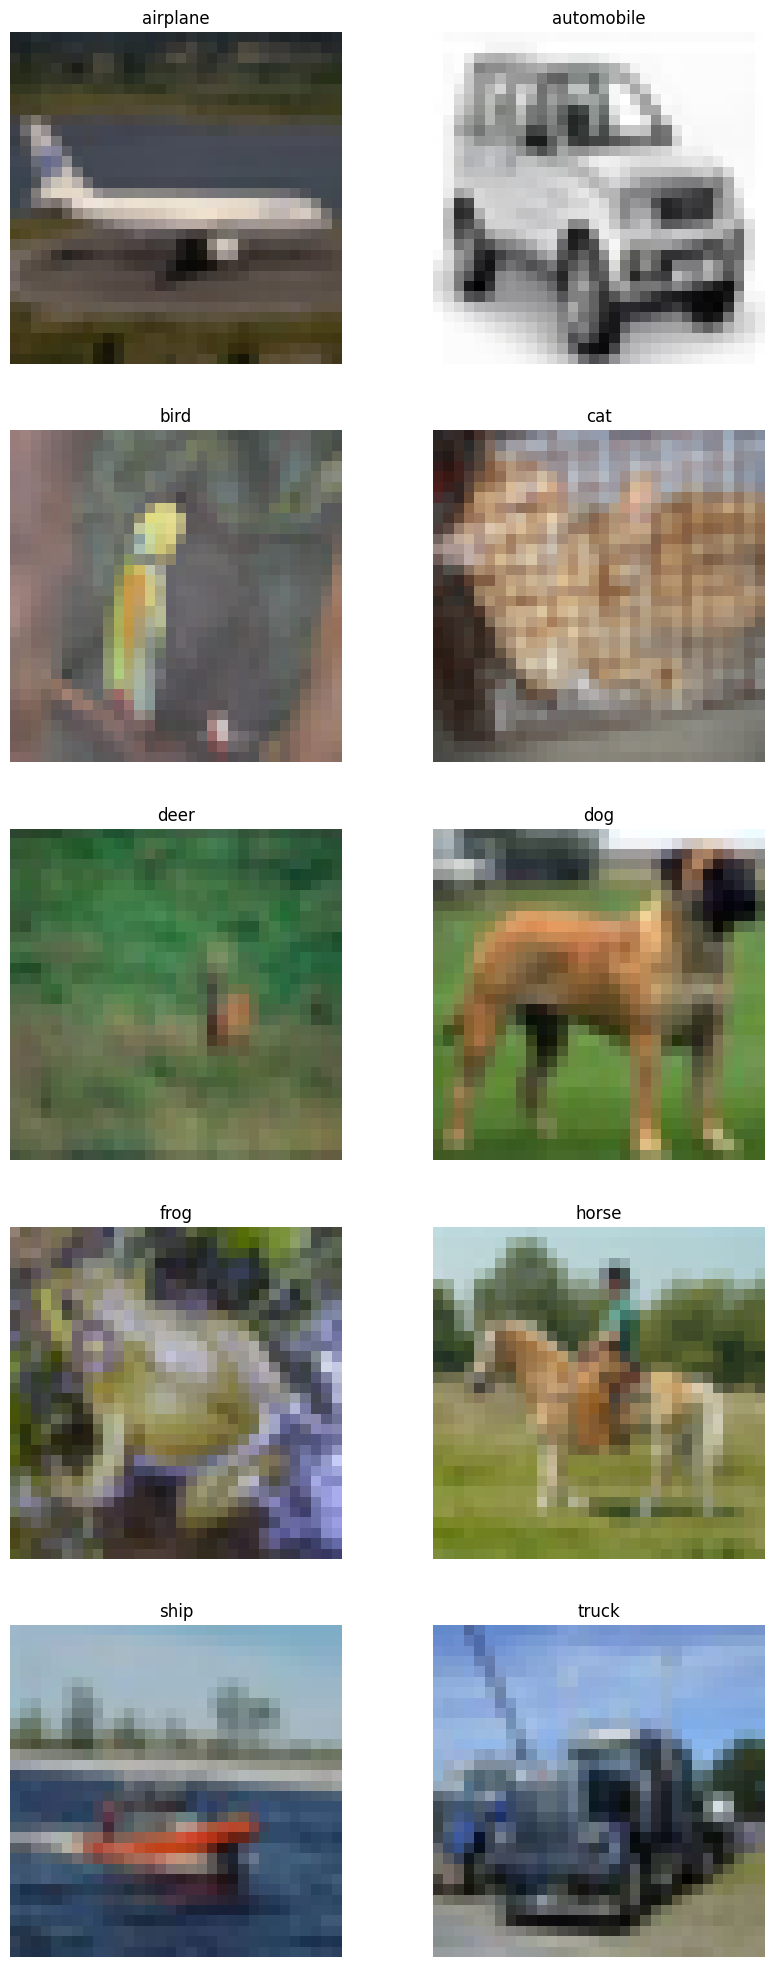

In [5]:
def show_images(dataset='train'):
    next_pix= []
    # Parameters for our graph; we'll output images in a 5x2 configuration
    nrows = 5
    ncols = 2

    fig = plt.gcf()
    fig.set_size_inches(ncols * 5, nrows * 5)
    for i in range(len(classes)):
        next_pix.append(os.path.join(data_dir,dataset,classes[i]))
        img = mpimg.imread(os.path.join(next_pix[i],random.choice(os.listdir(next_pix[i]))))
        # Set up subplot; subplot indices start at 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off') # Don't show axes (or gridlines)
        plt.imshow(img)
        plt.title(classes[i])
show_images('test')

In [6]:
dataset = torchvision.datasets.ImageFolder(data_dir+'/', transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=512)

Подсчёт коэффициентов для нормализации изображения

In [7]:
# def get_mean_and_std(dataloader):
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0
#     for data, _ in dataloader:
#         # Mean over batch, height and width, but not over the channels
#         channels_sum += torch.mean(data, dim=[0,2,3])
#         channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
#         num_batches += 1
    
#     mean = channels_sum / num_batches

#     # std = sqrt(E[X^2] - (E[X])^2)
#     std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
#     print(channels_sum,channels_squared_sum,num_batches)
#     return mean, std

In [8]:
# print(get_mean_and_std(dataloader))

In [9]:
stats = ((0.5, 0.5, 0.5), (0.3, 0.3, 0.3))
train_tfms = transforms.Compose(
    [transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
    transforms.ToTensor(), 
    transforms.Normalize(*stats,inplace=True)])
valid_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])

In [10]:
trainset = torchvision.datasets.ImageFolder(data_dir+'/train', train_tfms)
testset = torchvision.datasets.ImageFolder(data_dir+'/test', valid_tfms)

batch_size = 400

trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size*2, num_workers=2, pin_memory=True)

Проверка доступности устройства Cuda, а также пересылка модели и датасетов на это устройство, в противном случае переносим на Cpu

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


device = get_default_device()
print(device)

trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)

cuda


Определяем функцию для подсчёта точности и потерь


In [12]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Немного расширим для удобства нашу модель

In [13]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)  
        return loss,acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, last_lr: {:.5f}".format(
            epoch+1, result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_acc'], result['lrs'][-1]))

Модель ResNet34

In [14]:
def conv_block(in_channels, out_channels, activation=False, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels)]
    if activation: layers.append(nn.ReLU(inplace=True))
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet34(ImageClassificationBase):
    def __init__(self, in_channels = 3, num_classes = 10):
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=4),
            nn.BatchNorm2d(64),nn.ReLU(inplace=True))
           
        self.res1 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.res2 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.res3 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.downsample1=nn.Sequential(conv_block(64, 128,pool=True)) 
        self.res4 = nn.Sequential(conv_block(64, 128,activation=True, pool=True),
                                  conv_block(128,128))
        self.res5 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res6 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res7 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res8 = nn.Sequential(conv_block(128, 256,activation=True, pool=True),
                                  conv_block(256,256))
        self.downsample2 = nn.Sequential(conv_block(128, 256,pool=True))
        self.res9 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res10 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res11 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res12 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res13 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res14 = nn.Sequential(conv_block(256, 512,activation=True, pool=True),
                                   conv_block(512,512))
        
        self.downsample3 = nn.Sequential(conv_block(256, 512,pool=True))
        self.res15 = nn.Sequential(conv_block(512, 512,activation=True), conv_block(512, 512))
        self.res16 = nn.Sequential(conv_block(512, 512,activation=True), conv_block(512, 512,activation=True))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        self.apply(self.init_weights)

    def init_weights(self,m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.res2(out) + out
        out = self.res3(out) + out
        out = self.downsample1(out) +self.res4(out)
        out = self.res5(out) + out
        out = self.res6(out) + out
        out = self.res7(out) + out
        out = self.downsample2(out) +self.res8(out)
        out = self.res9(out) + out
        out = self.res10(out) + out
        out = self.res11(out) + out
        out = self.res12(out) + out
        out = self.res13(out) + out
        out = self.downsample3(out) + self.res14(out) 
        out = self.res15(out) + out
        out = self.res16(out) + out
        out = self.classifier(out)
        return out
net = ResNet34()
net.to(device)

ResNet34(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(4, 4))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (res2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

3. Определим функцию ошибки и градент
=======================================

Воспользуемся кросс-энтропийной функцией ошибки и стохастическим градиентным спуском с импульсом


In [15]:
import torch.optim as optim
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,weight_decay=0, 
        bias_clip=False,grad_clip=None, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func
    best_accuracy=0.00000
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,eta_min=0.000015,T_max=epochs*len(train_loader))
    for epoch in (range(epochs)):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracy= []
        lrs=[]
        for (batch_idx, batch) in enumerate(train_loader):
            loss,accuracy = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accuracy)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            if bias_clip:
                params=model.state_dict()
                for name, param in model.named_parameters():
                    if 'bias' in name:
                        # Access the biases
                        params[name][:]=torch.clip(param, min=-0.055, max=0.045)
                model.load_state_dict(params)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        if result['val_acc']>best_accuracy:
            torch.save(model.state_dict(), 'cifar10-resnet34best.pth')
            best_accuracy=result['val_acc']
    return history

Проверим точность нашей модели до тренировки

In [16]:
evaluate(net, testloader)

{'val_loss': 5120.8818359375, 'val_acc': 0.09615384787321091}

Введём гиперпараметры: кол-во эпох, скорсоть обучения и есть ли сдвин(bias) и какую функцию оптимизации используем



In [17]:
epochs = 60
max_lr = 0.00155
grad_clip = 0.71
weight_decay = 0.0001
bias_clip=True
opt_func = torch.optim.Adam(net.parameters(),max_lr,amsgrad=True
                            , weight_decay=weight_decay)

In [18]:
%%time
history = fit_one_cycle(epochs, max_lr, net, trainloader, testloader, 
                             grad_clip=grad_clip,
                            bias_clip=bias_clip,
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [1], train_loss: 2.0699, train_acc: 0.3139, val_loss: 1.5824, val_acc: 0.4180, last_lr: 0.00155
Epoch [2], train_loss: 1.5471, train_acc: 0.4402, val_loss: 1.5079, val_acc: 0.4675, last_lr: 0.00155
Epoch [3], train_loss: 1.3137, train_acc: 0.5366, val_loss: 1.2436, val_acc: 0.5434, last_lr: 0.00154
Epoch [4], train_loss: 1.1242, train_acc: 0.6089, val_loss: 1.0525, val_acc: 0.6506, last_lr: 0.00153
Epoch [5], train_loss: 0.9534, train_acc: 0.6677, val_loss: 1.0180, val_acc: 0.6593, last_lr: 0.00152
Epoch [6], train_loss: 0.8172, train_acc: 0.7164, val_loss: 0.8156, val_acc: 0.7349, last_lr: 0.00151
Epoch [7], train_loss: 0.7328, train_acc: 0.7465, val_loss: 0.6842, val_acc: 0.7667, last_lr: 0.00150
Epoch [8], train_loss: 0.6551, train_acc: 0.7736, val_loss: 0.6723, val_acc: 0.7697, last_lr: 0.00148
Epoch [9], train_loss: 0.5887, train_acc: 0.7988, val_loss: 0.5937, val_acc: 0.8006, last_lr: 0.00147
Epoch [10], train_loss: 0.5344, train_acc: 0.8153, val_loss: 0.6950, val_acc: 0.77

Введём функции, которые построят графики изменения точности, потерь

In [19]:
def plot_accuracies(history):
    train_accuracies= [x['train_accuracy'] for x in history]
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-bx')
    plt.plot(train_accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Validation','Training'])
    plt.title('Accuracy vs. No. of epochs')

In [20]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

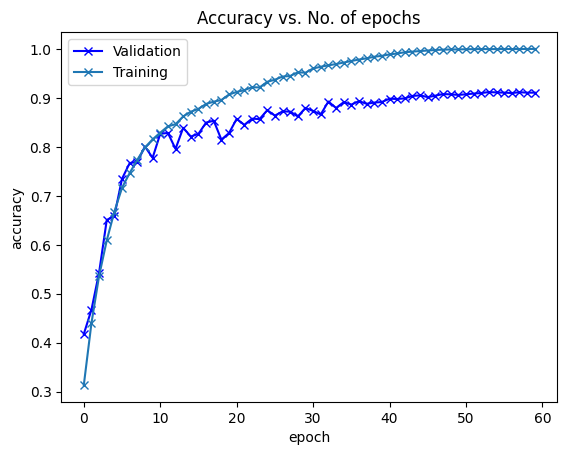

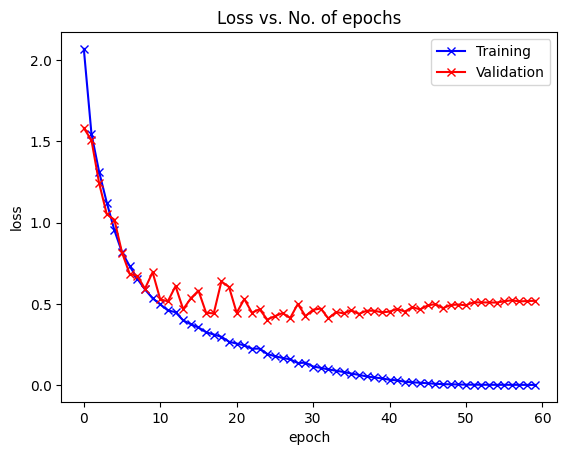

In [21]:

plot_accuracies(history)
plt.show()
plot_losses(history)
plt.show()

Сохраним нашу нейронную модель


In [22]:
torch.save(net.state_dict(), 'cifar10-resnet34.pth')

Загрузим нашу модель для проверки


In [23]:

net2 = to_device(ResNet34(), device)

In [24]:
net2.load_state_dict(torch.load('cifar10-resnet34.pth'))

C:\Users\Otche\AppData\Local\Temp\ipykernel_7848\903138478.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net2.load_state_dict(torch.load('cifar10-resnet34.pth'))


<All keys matched successfully>

In [25]:
evaluate(net2, testloader)
net2.load_state_dict(torch.load('cifar10-resnet34.pth'))

C:\Users\Otche\AppData\Local\Temp\ipykernel_7848\1809799108.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net2.load_state_dict(torch.load('cifar10-resnet34.pth'))


<All keys matched successfully>

In [26]:
netbest=to_device(ResNet34(3, 10), device)
netbest.load_state_dict(torch.load('cifar10-resnet34best.pth'))

C:\Users\Otche\AppData\Local\Temp\ipykernel_7848\666967575.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netbest.load_state_dict(torch.load('cifar10-resnet34best.pth')

<All keys matched successfully>

In [27]:
evaluate(netbest, testloader)

{'val_loss': 0.508653461933136, 'val_acc': 0.9118269681930542}